#### Import Libraries

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

In [14]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [132]:
import requests
import bs4
import re
from selenium import webdriver
import time
from random import randint
from time import sleep
import sqlalchemy
import random
import copy

### Data Processing

#### Processing: names & titles known for

In [4]:
actor_name = pd.read_csv('./Data/name.basics.tsv.gz',compression='gzip', header=0, sep='\t', quotechar='"')
actor_name.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0072308,tt0045537,tt0053137,tt0050419"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0037382,tt0071877,tt0038355,tt0117057"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0054452,tt0057345,tt0049189,tt0056404"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0078723,tt0077975,tt0080455,tt0072562"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0083922,tt0060827,tt0050986,tt0050976"


In [6]:
# actor_name['knownForTitles'].value_counts()
# Notes: usually 4 "known for" but there can be 1, 2, 3 etc tt0123338 = TVSeries
actor_name.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12331499 entries, 0 to 12331498
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   nconst             object
 1   primaryName        object
 2   birthYear          object
 3   deathYear          object
 4   primaryProfession  object
 5   knownForTitles     object
dtypes: object(6)
memory usage: 564.5+ MB


In [7]:
actor_name_cp = actor_name

#### Function: clean \N values

In [16]:
def clean_N(df, col, replace, type):
    """
    Replace \N value in a column, replace it with a value of choice and reset the type of the column
    """
    df[col] = df[col].replace('\\N', replace)
    df[col] = df[col].astype(type)
    return df[col].value_counts().sort_index()

In [9]:
clean_N(actor_name_cp, 'birthYear', 1000, 'int64')
clean_N(actor_name_cp, 'deathYear', 2023, 'int64')

17             2
50             1
65             1
66             1
95             1
113            1
122            1
140            2
165            1
235            1
322            1
430            1
444            1
485            1
632            1
682            1
840            1
858            1
1022           1
1031           1
1123           1
1155           1
1179           1
1191           1
1220           1
1227           1
1250           1
1273           1
1274           1
1280           1
1306           1
1307           1
1321           1
1327           1
1350           1
1361           1
1375           1
1392           1
1400           3
1408           1
1431           1
1448           1
1463           1
1468           2
1470           1
1471           1
1473           1
1475           1
1476           1
1479           1
1483           1
1488           1
1491           1
1497           1
1506           1
1513           1
1516           1
1517           1
1519          

In [ ]:
# actor_name_cp.dtypes

nconst               object
primaryName          object
birthYear             int64
deathYear             int64
primaryProfession    object
knownForTitles       object
dtype: object

In [ ]:
# actor_name_cp.describe()

,birthYear,deathYear
count,1.233150e+07,1.233150e+07
mean,1.044141e+03,2.022466e+03
std,2.003582e+02,6.080419e+00
min,4.000000e+00,1.700000e+01
25%,1.000000e+03,2.023000e+03
50%,1.000000e+03,2.023000e+03
75%,1.000000e+03,2.023000e+03
max,2.022000e+03,2.023000e+03


In [10]:
actor_name_cp = actor_name_cp.rename({'deathYear':'lastSeen'}, axis=1)
actor_name_clean = actor_name_cp[(actor_name_cp['birthYear'] >= 1900) & (actor_name_cp['lastSeen'] > 1926)]

In [11]:
actor_name_clean.to_csv("./Data/actor_name_clean.csv")

In [242]:
actor_name_clean.head()

,nconst,primaryName,birthYear,lastSeen,primaryProfession,knownForTitles
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0037382,tt0071877,tt0038355,tt0117057"
2,nm0000003,Brigitte Bardot,1934,2023,"actress,soundtrack,music_department","tt0054452,tt0057345,tt0049189,tt0056404"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0078723,tt0077975,tt0080455,tt0072562"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0083922,tt0060827,tt0050986,tt0050976"
5,nm0000006,Ingrid Bergman,1915,1982,"actress,soundtrack,producer","tt0038787,tt0034583,tt0038109,tt0036855"


In [246]:
len(actor_name_clean.primaryName.unique())

# 531334 unique names / nconst
# 513547 primary names

513547

In [282]:
actor_name_clean2 = actor_name_clean.drop('primaryProfession', axis = 1)
actor_title_k4 = actor_name_clean2['knownForTitles'].str.split(',', expand = True).fillna(np.nan).replace([np.nan], 'None')
actor_title_k4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531334 entries, 1 to 12331474
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       531334 non-null  object
 1   1       531334 non-null  object
 2   2       531334 non-null  object
 3   3       531334 non-null  object
 4   4       531334 non-null  object
dtypes: object(5)
memory usage: 24.3+ MB


In [284]:
actor_title_k4.columns = ['tt1','tt2','tt3','tt4','tt5']
actor_title_k4 = actor_title_k4.drop('tt5', axis=1)

actor_title_k4.head(10)

,0,1,2,3,4
1,tt0037382,tt0071877,tt0038355,tt0117057,None
2,tt0054452,tt0057345,tt0049189,tt0056404,None
3,tt0078723,tt0077975,tt0080455,tt0072562,None
4,tt0083922,tt0060827,tt0050986,tt0050976,None
5,tt0038787,tt0034583,tt0038109,tt0036855,None
7,tt0078788,tt0047296,tt0068646,tt0070849,None
8,tt0059749,tt0057877,tt0087803,tt0061184,None
10,tt0044706,tt0035896,tt0027996,tt0034167,None
11,tt0031210,tt0035140,tt0056687,tt0042192,None
12,tt0045591,tt0048317,tt0049470,tt0053172,None


In [12]:
# title_akas = pd.read_csv('./Data/title.akas.tsv.gz',compression='gzip', header=0, sep='\t', quotechar='"')
# # title_akas.head()

In [13]:
clean_N(title_akas,'region','OTH', 'object')
clean_N(title_akas,'types','Others', 'object')
clean_N(title_akas,'attributes','Others', 'object')
clean_N(title_akas,'language','OTH', 'object')

OTH    6513059
af         153
am           1
ar        1254
az          77
be          18
bg       26299
bn         413
br           1
bs         388
ca        3039
cmn      21587
cr           1
cs        1209
cy          86
da          14
de     3961298
eka          1
el          41
en      445004
es     3961854
et          33
eu         112
fa        3381
fi          17
fr     4017634
fro          1
ga         140
gd          48
gl         163
gsw         74
gu          80
haw          1
he        7934
hi     3991475
hr        1614
hu          26
hy          28
id         542
is           2
it     3959934
iu           1
ja     4052704
jsl          1
jv           1
ka          55
kk          36
kn         183
ko          13
ku           3
ky           3
la         128
lb           6
lo           1
lt          39
lv          75
mi          46
mk          64
ml         877
mn           4
mr         176
ms         309
my           1
myv          1
ne           1
nl        1457
no        

#### Processing: title akas

In [14]:
title_akas_count = title_akas.groupby(by='titleId').count().reset_index()
# type(title_akas_count)

In [15]:
title_akas_count.head()

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,8,8,8,8,8,8,8
1,tt0000002,8,8,8,8,8,8,8
2,tt0000003,9,9,9,9,9,9,9
3,tt0000004,8,8,8,8,8,8,8
4,tt0000005,12,12,12,12,12,12,12


In [21]:
title_akas_count = title_akas_count[['titleId','ordering']]
title_akas_count.columns = ['titleId', 'count_akas']

In [ ]:
# title_akas[title_akas['isOriginalTitle'] == 1].language.value_counts()
# in complete data. Original title's languages/ region do not correspond to the title...almost 496k are "1"

OTH    496537
en          2
ja          1
da          1
ca          1
Name: language, dtype: int64

In [22]:
title_akas_count.to_csv('./Data/title_akas_count.csv')
# number of exposure per title

In [ ]:
# title_akas_cp.types.value_counts()
# types = original, alternative, working, dvd, etc. KIV

OTH                     29559853
imdbDisplay              3431988
original                 1805437
alternative               108398
working                    53404
dvd                        21882
video                      20663
festival                   18970
tv                         18453
dvdimdbDisplay              233
imdbDisplaytv                74
festivalimdbDisplay          66
imdbDisplayworking           31
imdbDisplayvideo             26
alternativetv                 9
tvvideo                       7
alternativedvd                6
videoworking                  5
alternativeworking            5
tvworking                     4
festivalworking               3
dvdvideo                      2
alternativevideo              2
alternativefestival           2
Name: types, dtype: int64

#### Processing: title basics

In [17]:
title_basics = pd.read_csv('../dev_data/title.basics.tsv.gz',compression='gzip', header=0, sep='\t', quotechar='"')
title_basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [18]:
# title_basics.dtypes
clean_N(title_basics, 'startYear', 1800, 'int64')
clean_N(title_basics, 'endYear', 2024, 'int64')
title_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9650055 entries, 0 to 9650054
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         object
 5   startYear       int64 
 6   endYear         int64 
 7   runtimeMinutes  object
 8   genres          object
dtypes: int64(2), object(7)
memory usage: 662.6+ MB


In [19]:
title_basics['runtimeMinutes'].fillna(0, inplace=True)
title_basics[title_basics['runtimeMinutes'].str.contains('Animation').fillna(False)]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
2996552,tt13704268,tvEpisode,Bay of the Triffids/Doctor of Doom\tBay of the...,0,\N,1800,2024,"Animation,Comedy,Family",NaN


In [20]:
title_basics.loc[1097575, 'runtimeMinutes'] = 0 #Reality
title_basics.loc[2307000, 'runtimeMinutes'] = 0
title_basics.loc[6971789, 'runtimeMinutes'] = 0

title_basics.loc[1508289, 'runtimeMinutes'] = 0 #Talk show
title_basics.loc[2007336, 'runtimeMinutes'] = 0
title_basics.loc[9606673, 'runtimeMinutes'] = 0
title_basics.loc[9646510, 'runtimeMinutes'] = 0

title_basics.loc[1896328, 'runtimeMinutes'] = 0 #Documentary

title_basics.loc[2161668, 'runtimeMinutes'] = 0 #Game

title_basics.loc[2996552, 'runtimeMinutes'] = 0 #Animation


In [21]:
clean_N(title_basics, 'runtimeMinutes', 0, 'int64')
title_basics['runtimeMinutes'].value_counts()

0       6820624
30       213277
60       148594
22       148507
15        74669
         ...   
776           1
784           1
785           1
789           1
7777          1
Name: runtimeMinutes, Length: 878, dtype: int64

In [ ]:
# title_basics

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,2024,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,2024,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,2024,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,2024,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,2024,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
9650050,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2010,2024,0,"Action,Drama,Family"
9650051,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,2024,0,"Action,Drama,Family"
9650052,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010,2024,0,"Action,Drama,Family"
9650053,tt9916856,short,The Wind,The Wind,0,2015,2024,27,Short


In [22]:
movie_type = ['movie', 'tvMovie']
title_movies_clean = title_basics[((title_basics['endYear'] < 2023) 
                                    | (title_basics['startYear'] > 1926))
                                    & (title_basics['titleType'].isin(movie_type))]

In [29]:
# title_movies_clean.titleType.value_counts()

movie      519407
tvMovie    136686
Name: titleType, dtype: int64

In [24]:
list_title_movies = list(title_movies_clean.tconst.unique())
len(list_title_movies)

656093

In [25]:
list_title_movies

['tt0003854',
 'tt0011715',
 'tt0011801',
 'tt0013274',
 'tt0014985',
 'tt0015152',
 'tt0015414',
 'tt0015724',
 'tt0015737',
 'tt0016029',
 'tt0016035',
 'tt0016101',
 'tt0016576',
 'tt0016620',
 'tt0016624',
 'tt0016712',
 'tt0016721',
 'tt0016755',
 'tt0016772',
 'tt0016788',
 'tt0016876',
 'tt0016904',
 'tt0016906',
 'tt0016920',
 'tt0016970',
 'tt0016971',
 'tt0016985',
 'tt0016997',
 'tt0017000',
 'tt0017009',
 'tt0017017',
 'tt0017043',
 'tt0017045',
 'tt0017065',
 'tt0017073',
 'tt0017075',
 'tt0017102',
 'tt0017105',
 'tt0017136',
 'tt0017147',
 'tt0017193',
 'tt0017273',
 'tt0017292',
 'tt0017352',
 'tt0017399',
 'tt0017413',
 'tt0017418',
 'tt0017511',
 'tt0017516',
 'tt0017534',
 'tt0017578',
 'tt0017581',
 'tt0017588',
 'tt0017589',
 'tt0017590',
 'tt0017591',
 'tt0017592',
 'tt0017593',
 'tt0017594',
 'tt0017595',
 'tt0017596',
 'tt0017597',
 'tt0017598',
 'tt0017599',
 'tt0017617',
 'tt0017619',
 'tt0017621',
 'tt0017622',
 'tt0017623',
 'tt0017624',
 'tt0017626',
 'tt00

In [23]:
clean_N(title_movies_clean, 'genres', 'None', 'object')

Action                    10703
Action,Adult                 11
Action,Adult,Adventure        2
Action,Adult,Comedy           4
Action,Adult,Crime           13
                          ...  
Thriller,War,Western          2
Thriller,Western             20
War                        1043
War,Western                  11
Western                    3449
Name: genres, Length: 1490, dtype: int64

In [26]:
titleId_genres = title_movies_clean.genres.str.split(",", expand=True)
titleId_genres.columns = ['genres1','genres2','genres3']

titleId_basics_genres_sep = pd.concat([title_movies_clean, titleId_genres], axis=1)
titleId_basics_genres_sep.head()


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,genres1,genres2,genres3
3816,tt0003854,movie,Dodge City Trail,Dodge City Trail,0,1936,2024,56,"Adventure,Music,Western",Adventure,Music,Western
11551,tt0011715,movie,Sol de gloria,Sol de gloria,0,1928,2024,0,"Drama,Romance",Drama,Romance,None
11636,tt0011801,movie,Tötet nicht mehr,Tötet nicht mehr,0,2019,2024,0,"Action,Crime",Action,Crime,None
13082,tt0013274,movie,Istoriya grazhdanskoy voyny,Istoriya grazhdanskoy voyny,0,2021,2024,133,Documentary,Documentary,None,None
14752,tt0014985,movie,A Hero for a Night,A Hero for a Night,0,1927,2024,60,Comedy,Comedy,None,None


In [27]:
titleId_basics_genres_sep = titleId_basics_genres_sep.fillna(np.nan).replace([np.nan], 'None')
titleId_basics_genres_sep[titleId_basics_genres_sep['genres3'] == 'None']

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,genres1,genres2,genres3
11551,tt0011715,movie,Sol de gloria,Sol de gloria,0,1928,2024,0,"Drama,Romance",Drama,Romance,None
11636,tt0011801,movie,Tötet nicht mehr,Tötet nicht mehr,0,2019,2024,0,"Action,Crime",Action,Crime,None
13082,tt0013274,movie,Istoriya grazhdanskoy voyny,Istoriya grazhdanskoy voyny,0,2021,2024,133,Documentary,Documentary,None,None
14752,tt0014985,movie,A Hero for a Night,A Hero for a Night,0,1927,2024,60,Comedy,Comedy,None,None
14918,tt0015152,movie,Mustalaishurmaaja,Mustalaishurmaaja,0,1929,2024,69,"Drama,Romance",Drama,Romance,None
...,...,...,...,...,...,...,...,...,...,...,...,...
9649973,tt9916680,movie,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,0,2007,2024,100,Documentary,Documentary,None,None
9649978,tt9916692,tvMovie,Teatroteka: Czlowiek bez twarzy,Teatroteka: Czlowiek bez twarzy,0,2015,2024,66,Drama,Drama,None,None
9649985,tt9916706,movie,Dankyavar Danka,Dankyavar Danka,0,2013,2024,0,Comedy,Comedy,None,None
9649995,tt9916730,movie,6 Gunn,6 Gunn,0,2017,2024,116,None,None,None,None


In [28]:
titleId_basics_genres_sep.isnull().sum()

tconst            0
titleType         0
primaryTitle      0
originalTitle     0
isAdult           0
startYear         0
endYear           0
runtimeMinutes    0
genres            0
genres1           0
genres2           0
genres3           0
dtype: int64

In [38]:
titleId_basics_genres_sep.genres1.value_counts()

Drama           158711
Documentary     140126
Comedy          102550
None             67435
Action           44849
Crime            22026
Biography        17816
Adventure        17329
Horror           16225
Thriller          9284
Adult             9038
Romance           7192
Music             7087
Family            6511
Animation         6248
Musical           3892
Mystery           3568
Fantasy           3482
Western           3449
Sci-Fi            2495
History           2089
Sport             1917
Reality-TV        1076
War               1054
News               315
Talk-Show          231
Game-Show           59
Film-Noir           33
Short                5
Experimental         1
Name: genres1, dtype: int64

In [30]:
titleId_basics_genres_sep.to_csv('./Data/title_movies_genres.csv')

In [30]:
all_genres = pd.concat([titleId_basics_genres_sep.genres1, titleId_basics_genres_sep.genres2, titleId_basics_genres_sep.genres3])
all_genres.drop_duplicates(keep = 'first', inplace=True)
all_genres = list(all_genres)

#### Processing: encoding genres

In [31]:
# LE from 1 list of all genres
le = LabelEncoder()
le.fit(all_genres)
encoded_genres1 = pd.DataFrame(le.transform(titleId_basics_genres_sep.genres1))
encoded_genres2 = pd.DataFrame(le.transform(titleId_basics_genres_sep.genres2))
encoded_genres3 = pd.DataFrame(le.transform(titleId_basics_genres_sep.genres3))
type(encoded_genres1)

pandas.core.frame.DataFrame

In [39]:
genres_df = pd.concat([encoded_genres1, encoded_genres2, encoded_genres3], axis = 1)
genres_df.columns = ['encoded_genres1','encoded_genres2','encoded_genres3']
genres_df.head(30)
# genres_df.info()


,encoded_genres1,encoded_genres2,encoded_genres3
0,2,16,29
1,8,22,20
2,0,6,20
3,7,20,20
4,5,20,20
5,8,22,20
6,20,20,20
7,8,18,22
8,5,20,20
9,5,10,16


In [40]:
titleId_basics_genres_sep.reset_index(drop=True, inplace=True)
genres_df.reset_index(drop=True, inplace=True)

In [41]:
titleId_basics_genres_coded = pd.concat([titleId_basics_genres_sep, genres_df], axis=1)

In [42]:
titleID_movies_genres_coded = titleId_basics_genres_coded[titleId_basics_genres_coded['runtimeMinutes'] > 40]

In [43]:
titleID_movies_genres_coded.head(30)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,genres1,genres2,genres3,encoded_genres1,encoded_genres2,encoded_genres3
0,tt0003854,movie,Dodge City Trail,Dodge City Trail,0,1936,2024,56,"Adventure,Music,Western",Adventure,Music,Western,2,16,29
3,tt0013274,movie,Istoriya grazhdanskoy voyny,Istoriya grazhdanskoy voyny,0,2021,2024,133,Documentary,Documentary,None,None,7,20,20
4,tt0014985,movie,A Hero for a Night,A Hero for a Night,0,1927,2024,60,Comedy,Comedy,None,None,5,20,20
5,tt0015152,movie,Mustalaishurmaaja,Mustalaishurmaaja,0,1929,2024,69,"Drama,Romance",Drama,Romance,None,8,22,20
6,tt0015414,movie,La tierra de los toros,La tierra de los toros,0,2000,2024,60,None,None,None,None,20,20,20
7,tt0015724,movie,Dama de noche,Dama de noche,0,1993,2024,102,"Drama,Mystery,Romance",Drama,Mystery,Romance,8,18,22
9,tt0016029,movie,The Little Colonel,The Little Colonel,0,1935,2024,81,"Comedy,Family,Music",Comedy,Family,Music,5,10,16
17,tt0016755,movie,El cura de aldea,El cura de aldea,0,1927,2024,60,Drama,Drama,None,None,8,20,20
21,tt0016904,movie,The Fourth Commandment,The Fourth Commandment,0,1927,2024,70,"Drama,Music,Romance",Drama,Music,Romance,8,16,22
22,tt0016906,movie,Frivolinas,Frivolinas,0,1927,2024,80,"Comedy,Musical",Comedy,Musical,None,5,17,20


In [44]:
titleID_movies_genres_coded.to_csv('./Data/title_movies_gcoded_40min.csv')

In [249]:
titleId_basics_genres_coded[titleId_basics_genres_coded['tconst'] == 'tt6710474']

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,genres1,genres2,genres3,encoded_genres1,encoded_genres2,encoded_genres3
595808,tt6710474,movie,Everything Everywhere All at Once,Everything Everywhere All at Once,0,2022,2024,139,"Action,Adventure,Comedy",Action,Adventure,Comedy,0,2,5


In [87]:
# title_movies_clean.to_csv('./Data/title_movies_clean.csv')

In [32]:
title_crew = pd.read_csv('./Data/title.crew.tsv.gz',compression='gzip', header=0, sep='\t', quotechar='"')
# titleId, directors, writers

In [ ]:
# title_eps = pd.read_csv('../../../thaopham/Downloads/title.episode.tsv.gz',compression='gzip', header=0, sep='\t', quotechar='"')
# title_eps.head()

,tconst,parentTconst,seasonNumber,episodeNumber
0,tt0041951,tt0041038,1,9
1,tt0042816,tt0989125,1,17
2,tt0042889,tt0989125,\N,\N
3,tt0043426,tt0040051,3,42
4,tt0043631,tt0989125,2,16


#### Processing: title principle crew

In [9]:
title_prin = pd.read_csv('../dev_data/title.principals.tsv.gz',compression='gzip', header=0, sep='\t', quotechar='"')


In [36]:
title_prin.info()
# Many titles to each role (director, actor, producer)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54852111 entries, 0 to 54852110
Data columns (total 6 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   tconst      object
 1   ordering    int64 
 2   nconst      object
 3   category    object
 4   job         object
 5   characters  object
dtypes: int64(1), object(5)
memory usage: 2.5+ GB


In [152]:
title_prin.head()

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N


In [10]:
title_prin_slice = title_prin.loc[:,'tconst':'category']

In [273]:
title_prin_slice.category.unique()

array(['self', 'director', 'cinematographer', 'composer', 'producer',
       'editor', 'actor', 'actress', 'writer', 'production_designer',
       'archive_footage', 'archive_sound'], dtype=object)

In [20]:
title_principle_crew_m = title_prin_slice[title_prin_slice['tconst'].isin(list_title_movies)]

In [21]:
title_principle_crew_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4983088 entries, 20796 to 54851663
Data columns (total 4 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   tconst    object
 1   ordering  int64 
 2   nconst    object
 3   category  object
dtypes: int64(1), object(3)
memory usage: 190.1+ MB


In [22]:
title_principle_crew_m.to_csv('../dev_data/title_principle_crew.csv')

In [285]:
# title_rating = pd.read_csv('./Data/title.ratings.tsv.gz',compression='gzip', header=0, sep='\t', quotechar='"')
title_rating.head(5)

,tconst,averageRating,numVotes
0,tt0000001,5.70000,1956
1,tt0000002,5.80000,263
2,tt0000003,6.50000,1789
3,tt0000004,5.60000,179
4,tt0000005,6.20000,2593


In [241]:
title_rating['averageRating'].value_counts().sum()
# 1283871 ratings of titles in total (raw)

1283871

In [277]:
title_high_rating = title_rating[(title_rating['averageRating'] > 6) & (title_rating['averageRating'] < 10) & (title_rating['numVotes'] > 50)]

In [278]:
title_high_rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350843 entries, 2 to 1283855
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   tconst         350843 non-null  object 
 1   averageRating  350843 non-null  float64
 2   numVotes       350843 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 10.7+ MB


In [279]:
title_high_rating.to_csv('./Data/title_high_rating.csv')

### Web Scraping

#### Creating tables of ratings (by gender by age)

In [130]:
first_row = ['tt0000008', 5.4, 2097.0, 5.3, 1458.0, 5.6, 161.0, 6.0, 1.0, 0.0, 0.0, 6.0, 1.0, 5.5, 271.0, 5.5, 235.0, 5.5, 31.0, 5.2, 951.0, 5.2, 846.0, 5.5, 92.0, 5.5, 361.0, 5.5, 321.0, 6.0, 34.0] #len = 31
table_headers = ['tconst', 'all_all_ratings', 'all_all_v_counts', 'all_males_ratings', 'all_males_v_counts', 'all_females_ratings', 'all_females_v_counts', 'under_18_all_ratings', 'under_18_all_v_counts', 'under_18_males_ratings', 'under_18_males_v_counts', 'under_18_females_ratings', 'under_18_females_v_counts', 'f18_29_all_ratings', 'f18_29_all_v_counts', 'f18_29_males_ratings', 'f18_29_males_v_counts', 'f18_29_females_ratings', 'f18_29_females_v_counts', 'f30_44_all_ratings', 'f30_44_all_v_counts', 'f30_44_males_ratings', 'f30_44_males_v_counts', 'f30_44_females_ratings', 'f30_44_females_v_counts', 'f45_all_ratings', 'f45_all_v_counts', 'f45_males_ratings', 'f45_males_v_counts', 'f45_females_ratings', 'f45_females_v_counts']

rating_list_fr = pd.DataFrame(first_row).T
rating_list_fr.columns = table_headers
rating_list_fr


,tconst,all_all_ratings,all_all_v_counts,all_males_ratings,all_males_v_counts,all_females_ratings,all_females_v_counts,under_18_all_ratings,under_18_all_v_counts,under_18_males_ratings,under_18_males_v_counts,under_18_females_ratings,under_18_females_v_counts,f18_29_all_ratings,f18_29_all_v_counts,f18_29_males_ratings,f18_29_males_v_counts,f18_29_females_ratings,f18_29_females_v_counts,f30_44_all_ratings,f30_44_all_v_counts,f30_44_males_ratings,f30_44_males_v_counts,f30_44_females_ratings,f30_44_females_v_counts,f45_all_ratings,f45_all_v_counts,f45_males_ratings,f45_males_v_counts,f45_females_ratings,f45_females_v_counts
0,tt0000008,5.40000,2097.00000,5.30000,1458.00000,5.60000,161.00000,6.00000,1.00000,0.00000,0.00000,6.00000,1.00000,5.50000,271.00000,5.50000,235.00000,5.50000,31.00000,5.20000,951.00000,5.20000,846.00000,5.50000,92.00000,5.50000,361.00000,5.50000,321.00000,6.00000,34.00000


#### Function: flatten rating table into a row

In [80]:
def rating_row(df, col):
        """
        To flatten a rating table (6x5) into a row (1x30), and add the title of this table as the first column
        """
        
        df_name = df[col].str.split(' ', expand=True).rename(columns={0:'ratings', 1:'drop', 2:'v_counts'}, index={0:'all', 1:'males', 2:'females'}).fillna(0)
        df_name.drop('drop',axis=1, inplace=True)
        df_name = df_name.stack()
        df_name.index = df_name.index.map('{0[0]}_{0[1]}'.format)
        df_name = df_name.to_frame().T
        df_name['age_group'] = col
        return df_name

#### Function: compile rows into a table

In [198]:
test_list_2 = ['tt0000008','tt0003854']
test_list_3 = ['tt0017009','tt0017352','tt0017632']
test_list_compile = [test_list_2, test_list_3]
no_table_list = []

def compile_rating_row_to_table(title_list):
    """
    To compile rows of ratings (generated by function rating_row) into a table
    """
    first_row = ['tt0000008', 5.4, 2097.0, 5.3, 1458.0, 5.6, 161.0, 6.0, 1.0, 0.0, 0.0, 6.0, 1.0, 5.5, 271.0, 5.5, 235.0, 5.5, 31.0, 5.2, 951.0, 5.2, 846.0, 5.5, 92.0, 5.5, 361.0, 5.5, 321.0, 6.0, 34.0] #len = 31
    table_headers = ['tconst', 'all_all_ratings', 'all_all_v_counts', 'all_males_ratings', 'all_males_v_counts', 'all_females_ratings', 'all_females_v_counts', 'under_18_all_ratings', 'under_18_all_v_counts', 'under_18_males_ratings', 'under_18_males_v_counts', 'under_18_females_ratings', 'under_18_females_v_counts', 'f18_29_all_ratings', 'f18_29_all_v_counts', 'f18_29_males_ratings', 'f18_29_males_v_counts', 'f18_29_females_ratings', 'f18_29_females_v_counts', 'f30_44_all_ratings', 'f30_44_all_v_counts', 'f30_44_males_ratings', 'f30_44_males_v_counts', 'f30_44_females_ratings', 'f30_44_females_v_counts', 'f45_all_ratings', 'f45_all_v_counts', 'f45_males_ratings', 'f45_males_v_counts', 'f45_females_ratings', 'f45_females_v_counts']
    rating_list_fr = pd.DataFrame(first_row).T
    rating_list_fr.columns = table_headers
    df_name = str(title_list[0]) + "_" + str(title_list[-1])
    for i, tconst in enumerate(title_list):
        try:
            url = f'https://www.imdb.com/title/{tconst}/ratings?ref_=tturv_sa_3'
            response = requests.get(url)
            soup = bs4.BeautifulSoup(response.content, 'lxml')
            table = soup.find('div', class_ = "allText")
            table_user_rating = pd.read_html(str(table))
            user_ratings = table_user_rating[1]
            user_ratings = user_ratings.replace('-','0 0 0')
            user_ratings = user_ratings.drop('Unnamed: 0', axis=1)
            columns = ['all','under_18','f18_29','f30_44','f45']

            user_ratings.columns = columns
            user_ratings = user_ratings.applymap(lambda val: re.sub(r'(\d*),(\d*)', r'\1\2', val))

            all_ages_ratings = rating_row(user_ratings, 'all')
            under_18_ratings = rating_row(user_ratings, 'under_18')
            f18_29_ratings = rating_row(user_ratings, 'f18_29')
            f30_44_ratings = rating_row(user_ratings, 'f30_44')
            f45_ratings = rating_row(user_ratings,'f45')

            ratings = pd.concat([all_ages_ratings, under_18_ratings, f18_29_ratings, f30_44_ratings, f45_ratings]).set_index("age_group")
            cols = ratings.columns
            ratings[cols] = ratings[cols].apply(pd.to_numeric, errors='coerce')
            ratings = ratings.stack()
            ratings.index = ratings.index.map('{0[0]}_{0[1]}'.format)
            ratings = ratings.to_frame().T
            ratings['tconst'] = tconst
            ratings = ratings[ ['tconst'] + [ col for col in ratings.columns if col != 'tconst' ]]
            rating_list_fr = pd.concat([rating_list_fr, ratings], axis = 0, ignore_index=True)

            sleep(random.uniform(0.2, 1.0))

        except Exception as ex:
            no_table_list.append(tconst)
            # print(ex)
    rating_list_fr.to_csv(f'../dev_data/{df_name}.csv')
    return len(rating_list_fr)

In [185]:
compile_rating_row_to_table(test_list_3)

['tt0017352']


3

#### Function: automate saving tables into csv

In [194]:
def export_titles_by_decade_to_csv(list_of_title_list):
    """
    Take in a list of title list, and export them to a csv file
    """
    for tt_lst in list_of_title_list:
        compile_rating_row_to_table(tt_lst)
        sleep(random.uniform(0.7, 2.0))
    print(no_table_list)
    return f'{len(list_of_title_list)} tables have been created'

In [195]:
export_titles_by_decade_to_csv(test_list_compile)

['tt0017352']


'2 tables have been created'

In [ ]:
no_table_list

#### Collecting: scraping for Oscars winners (all movies that won)

In [88]:
url_oscars_winner = 'https://www.imdb.com/list/ls055265443/?sort=release_date,desc&st_dt=&mode=simple&page=1&ref_=ttls_vw_smp'
response_winner = requests.get(url_oscars_winner)
soup_winner = bs4.BeautifulSoup(response_winner.content, 'lxml')

In [111]:
titleId_winner = soup_winner.find_all('div', class_ = "col-title")
titleId_winner_block = [element for element in titleId_winner]
titleId_winner_list = [element.find('a')['href'][7:-1] for element in titleId_winner_block]
len(titleId_winner_list)

# titleId_winner = soup_winner.find('div', class_ = "col-title").a['href'][7:-1]

100

In [127]:
titleId_winner_list_full = []
for i in range (1, 9):
    url_oscars_winner = f'https://www.imdb.com/list/ls055265443/?sort=release_date,desc&st_dt=&mode=simple&page={i}&ref_=ttls_vw_smp'
    response_winner = requests.get(url_oscars_winner)
    soup_winner = bs4.BeautifulSoup(response_winner.content, 'lxml')
    titleId_winner = soup_winner.find_all('div', class_ = "col-title")
    titleId_winner_block = [element for element in titleId_winner]
    titleId_winner_list = [element.find('a')['href'][7:-1] for element in titleId_winner_block]
    titleId_winner_list_full += titleId_winner_list

In [128]:
len(titleId_winner_list_full)

709

In [132]:
oscars_winner_list = pd.DataFrame(titleId_winner_list_full)
oscars_winner_list.drop_duplicates()
oscars_winner_list.columns = ['tconst']
oscars_winner_list['Winner'] = 'TRUE'
oscars_winner_list.to_csv("./Data/oscars_winner_imdb_list.csv")

In [105]:
# titleId_winner_year = soup_winner.find('div', class_ = "col-title").a.next_sibling.next_sibling.text.strip()
# titleId_winner_year

'(2021)'

#### Collecting: scraping for all nominees (titles & names)

In [153]:
url_nom = 'https://www.imdb.com/list/ls055903720/'
res_nom = requests.get(url_nom)
soup_nom = bs4.BeautifulSoup(res_nom.content, 'lxml')

<!DOCTYPE html>
<html xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#">
<head>
<meta charset="utf-8"/>
<script type="text/javascript">var IMDbTimer={starttime: new Date().getTime(),pt:'java'};</script>
<script>
    if (typeof uet == 'function') {
      uet("bb", "LoadTitle", {wb: 1});
    }
</script>
<script>(function(t){ (t.events = t.events || {})["csm_head_pre_title"] = new Date().getTime(); })(IMDbTimer);</script>
<title>All movies ever nominated for Oscar - IMDb</title>
<script>(function(t){ (t.events = t.events || {})["csm_head_post_title"] = new Date().getTime(); })(IMDbTimer);</script>
<script>
    if (typeof uet == 'function') {
      uet("be", "LoadTitle", {wb: 1});
    }
</script>
<script>
    if (typeof uex == 'function') {
      uex("ld", "LoadTitle", {wb: 1});
    }
</script>
<link href="https://www.imdb.com/list/ls055903720/" rel="canonical"/>
<meta content="http://www.imdb.com/list/ls055903720/" property="og:url"/>
<script>
    if (typeof uet ==

In [158]:
nominees = soup_nom.find_all('h3', class_ ="lister-item-header")
nominees_block = [element for element in nominees]
nominees_list_1 = [element.find('a')['href'][7:-1] for element in nominees_block]
# First 100 records of nominees list


['tt0018578',
 'tt0019304',
 'tt0018379',
 'tt0018455',
 'tt0017743',
 'tt0018806',
 'tt0019071',
 'tt0019553',
 'tt0019217',
 'tt0018253',
 'tt0019429',
 'tt0018389',
 'tt0019344',
 'tt0018515',
 'tt0019412',
 'tt0018429',
 'tt0018526',
 'tt0018945',
 'tt0018037',
 'tt0017979',
 'tt0017806',
 'tt0018129',
 'tt0017822',
 'tt0019451',
 'tt0019729',
 'tt0019630',
 'tt0019993',
 'tt0020018',
 'tt0019257',
 'tt0020499',
 'tt0020543',
 'tt0019788',
 'tt0020126',
 'tt0018674',
 'tt0020092',
 'tt0019824',
 'tt0019557',
 'tt0019833',
 'tt0018792',
 'tt0020081',
 'tt0020088',
 'tt0019237',
 'tt0019348',
 'tt0019398',
 'tt0019591',
 'tt0020603',
 'tt0019574',
 'tt0018907',
 'tt0019722',
 'tt0018666',
 'tt0019843',
 'tt0020629',
 'tt0020686',
 'tt0019823',
 'tt0020827',
 'tt0020112',
 'tt0020938',
 'tt0020690',
 'tt0019735',
 'tt0019785',
 'tt0021307',
 'tt0020823',
 'tt0021335',
 'tt0020641',
 'tt0021310',
 'tt0020488',
 'tt0020514',
 'tt0019959',
 'tt0021420',
 'tt0020594',
 'tt0020960',
 'tt00

In [159]:
titleID_nominees_list_full = []
for i in range (2, 36):
    url_oscars_nom = f'https://www.imdb.com/list/ls055903720/?sort=list_order,asc&st_dt=&mode=detail&page={i}'
    res_nom = requests.get(url_oscars_nom)
    soup_nom = bs4.BeautifulSoup(res_nom.content, 'lxml')
    nominees = soup_nom.find_all('h3', class_ ="lister-item-header")
    nominees_block = [element for element in nominees]
    nominees_list = [element.find('a')['href'][7:-1] for element in nominees_block]
    titleID_nominees_list_full += nominees_list

len(titleID_nominees_list_full)



3370

In [160]:
titleID_nominees_list_3470 = titleID_nominees_list_full + nominees_list_1
len(titleID_nominees_list_3470)

3470

In [161]:
titleID_nominees_list_3470 = pd.DataFrame(titleID_nominees_list_3470)
titleID_nominees_list_3470.drop_duplicates()
titleID_nominees_list_3470.columns = ['tconst']
titleID_nominees_list_3470['Nominees'] = 'TRUE'
titleID_nominees_list_3470.to_csv("./Data/oscars_nominees_imdb_list.csv")

In [267]:
titleID_nominees_list_3470[titleID_nominees_list_3470['tconst'] == 'tt0454876']
# nominated movies for 2023 are already included
# tt6710474 - Everything Everywhere All at Once
# included cinematography

,tconst,Nominees
2976,tt0454876,TRUE


In [261]:
# all actors & actresses nominated
nom_nconst = 'https://www.imdb.com/list/ls096107034/'
res_nconst = requests.get(nom_nconst)
soup_nconst = bs4.BeautifulSoup(res_nconst.content, 'lxml')
nom_nconst_bblock = soup_nconst.find_all('h3', class_ ="lister-item-header")
nom_nconst_block = [element for element in nom_nconst_bblock]
nom_nconst_list_1 = [element.find('a')['href'][6:]for element in nom_nconst_block]


In [263]:
nom_nconst = 'https://www.imdb.com/list/ls096107034/?sort=list_order,asc&mode=detail&page=2'
res_nconst = requests.get(nom_nconst)
soup_nconst = bs4.BeautifulSoup(res_nconst.content, 'lxml')
nom_nconst_bblock = soup_nconst.find_all('h3', class_ ="lister-item-header")
nom_nconst_block = [element for element in nom_nconst_bblock]
nom_nconst_list_2 = [element.find('a')['href'][6:]for element in nom_nconst_block]

In [264]:
dir_nconst = 'https://www.imdb.com/list/ls063355001/'
res_nconst = requests.get(dir_nconst)
soup_nconst = bs4.BeautifulSoup(res_nconst.content, 'lxml')
dir_nconst_bblock = soup_nconst.find_all('h3', class_ ="lister-item-header")
dir_nconst_block = [element for element in dir_nconst_bblock]
dir_nconst_list_1 = [element.find('a')['href'][6:]for element in dir_nconst_block]

In [265]:
dir_nconst = 'https://www.imdb.com/list/ls063355001/?sort=list_order,asc&mode=detail&page=2'
res_nconst = requests.get(dir_nconst)
soup_nconst = bs4.BeautifulSoup(res_nconst.content, 'lxml')
dir_nconst_bblock = soup_nconst.find_all('h3', class_ ="lister-item-header")
dir_nconst_block = [element for element in dir_nconst_bblock]
dir_nconst_list_2 = [element.find('a')['href'][6:]for element in dir_nconst_block]

In [266]:
dir_nconst = 'https://www.imdb.com/list/ls063355001/?sort=list_order,asc&mode=detail&page=3'
res_nconst = requests.get(dir_nconst)
soup_nconst = bs4.BeautifulSoup(res_nconst.content, 'lxml')
dir_nconst_bblock = soup_nconst.find_all('h3', class_ ="lister-item-header")
dir_nconst_block = [element for element in dir_nconst_bblock]
dir_nconst_list_3 = [element.find('a')['href'][6:]for element in dir_nconst_block]

In [274]:
# note: only updated till 2018
composer_nconst = 'https://www.imdb.com/list/ls026557238/'
res_nconst = requests.get(composer_nconst)
soup_nconst = bs4.BeautifulSoup(res_nconst.content, 'lxml')
composer_nconst_bblock = soup_nconst.find_all('h3', class_ ="lister-item-header")
composer_nconst_block = [element for element in composer_nconst_bblock]
composer_nconst_list = [element.find('a')['href'][6:]for element in dir_nconst_block]

In [275]:
# all actors, actress, directors, composers - nominated
nom_nconst = nom_nconst_list_1 + nom_nconst_list_2 + dir_nconst_list_1 + dir_nconst_list_2+dir_nconst_list_3 + composer_nconst_list
nom_nconst = pd.DataFrame(nom_nconst)
nom_nconst.columns = ['nconst']
nom_nconst['Nominees'] = 'TRUE'
nom_nconst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446 entries, 0 to 445
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   nconst    446 non-null    object
 1   Nominees  446 non-null    object
dtypes: object(2)
memory usage: 7.1+ KB


In [276]:
nom_nconst.to_csv("./Data/nconst_nominees_list_446.csv")

#### Collecting: scraping for production house

In [71]:
url_prod = 'https://www.the-numbers.com/movies/production-companies/#production_companies_overview=od1'

res_prod = requests.get(url_prod)
soup_prod = bs4.BeautifulSoup(res_prod.content, 'lxml')
soup_prod
# prod = soup_prod.find_all('h3', class_ ="lister-item-header")
# prod_block = [element for element in prod]
# prod_list = [element.find('a')['href'][7:-1] for element in nom_all_cat_block]

<!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">
<html><head>
<title>403 Forbidden</title>
</head><body>
<h1>Forbidden</h1>
<p>You don't have permission to access /movies/production-companies/
on this server.</p>
</body></html>

In [253]:
# all nominees by category for every year:
# url_nom_all_cat = 'https://www.imdb.com/event/ev0000003/1929/1/?ref_=ev_eh'
# res_nom_all_cat = requests.get(url_nom_all_cat)
# soup_nom_all_cat = bs4.BeautifulSoup(res_nom_all_cat.content, 'lxml')
# soup_nom_all_cat
# # nom_all_cat = soup_nom_all_cat.find_all('h3', class_ ="lister-item-header")
# # nom_all_cat_block = [element for element in nom_all_cat]
# # nom_all_cat_list = [element.find('a')['href'][7:-1] for element in nom_all_cat_block]

<!DOCTYPE html>
<html xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#">
<head>
<meta charset="utf-8"/>
<script type="text/javascript">var IMDbTimer={starttime: new Date().getTime(),pt:'java'};</script>
<script>
    if (typeof uet == 'function') {
      uet("bb", "LoadTitle", {wb: 1});
    }
</script>
<script>(function(t){ (t.events = t.events || {})["csm_head_pre_title"] = new Date().getTime(); })(IMDbTimer);</script>
<title>Academy Awards, USA (1929) - IMDb</title>
<script>(function(t){ (t.events = t.events || {})["csm_head_post_title"] = new Date().getTime(); })(IMDbTimer);</script>
<script>
    if (typeof uet == 'function') {
      uet("be", "LoadTitle", {wb: 1});
    }
</script>
<script>
    if (typeof uex == 'function') {
      uex("ld", "LoadTitle", {wb: 1});
    }
</script>
<link href="https://www.imdb.com/event/ev0000003/1929/1/" rel="canonical"/>
<meta content="http://www.imdb.com/event/ev0000003/1929/1/" property="og:url"/>
<script>
    if (typeof uet

In [ ]:
COFFEE BREAKS

### Draft - Testing Code Block

In [62]:
## LOOP TO CREATE DATABASE OF RATINGS
test_list   = ['tt0017009']
test_list_2 = ['tt0000008','tt0003854','tt0017009','tt0017352','tt0017632']
no_table_list = []


for i, tconst in enumerate(test_list_2):
    try:
        url = f'https://www.imdb.com/title/{tconst}/ratings?ref_=tturv_sa_3'
        response = requests.get(url)
        soup = bs4.BeautifulSoup(response.content, 'lxml')
        table = soup.find('div', class_ = "allText")
        table_user_rating = pd.read_html(str(table))
        user_ratings = table_user_rating[1]
        user_ratings = user_ratings.drop('Unnamed: 0', axis=1)
        columns = ['all','under_18','f18_29','f30_44','f45']
        user_ratings = user_ratings.replace('-','0 0 0')
        user_ratings.columns = columns
        user_ratings = user_ratings.applymap(lambda val: re.sub(r'(\d*),(\d*)', r'\1\2', val))

        all_ages_ratings = user_ratings['all'].str.split(' ', expand=True).rename(columns={0:'ratings', 1:'drop', 2:'v_counts'}, index={0:'all', 1:'males', 2:'females'}).fillna(0)
        all_ages_ratings.drop('drop',axis=1, inplace=True)
        all_ages_ratings = all_ages_ratings.stack()
        all_ages_ratings.index = all_ages_ratings.index.map('{0[0]}_{0[1]}'.format)
        all_ages_ratings = all_ages_ratings.to_frame().T
        all_ages_ratings['age_group'] = 'all'

        under_18_ratings = user_ratings['under_18'].str.split(' ', expand=True).rename(columns={0:'ratings', 1:'drop', 2:'v_counts'}, index={0:'all', 1:'males', 2:'females'}).fillna(0)
        under_18_ratings.drop('drop',axis=1, inplace=True)
        under_18_ratings = under_18_ratings.stack()
        under_18_ratings.index = under_18_ratings.index.map('{0[0]}_{0[1]}'.format)
        under_18_ratings = under_18_ratings.to_frame().T.fillna(0)
        under_18_ratings['age_group'] = 'under_18'

        f18_29_ratings = user_ratings['f18_29'].str.split(' ', expand=True).rename(columns={0:'ratings', 1:'drop', 2:'v_counts'}, index={0:'all', 1:'males', 2:'females'}).fillna(0)
        f18_29_ratings.drop('drop',axis=1, inplace=True)
        f18_29_ratings = f18_29_ratings.stack()
        f18_29_ratings.index = f18_29_ratings.index.map('{0[0]}_{0[1]}'.format)
        f18_29_ratings = f18_29_ratings.to_frame().T.fillna(0)
        f18_29_ratings['age_group'] = 'f18_29'

        f30_44_ratings = user_ratings['f30_44'].str.split(' ', expand=True).rename(columns={0:'ratings', 1:'drop', 2:'v_counts'}, index={0:'all', 1:'males', 2:'females'}).fillna(0)
        f30_44_ratings.drop('drop',axis=1, inplace=True)
        f30_44_ratings = f30_44_ratings.stack()
        f30_44_ratings.index = f30_44_ratings.index.map('{0[0]}_{0[1]}'.format)
        f30_44_ratings = f30_44_ratings.to_frame().T.fillna(0)
        f30_44_ratings['age_group'] = 'f30_44'

        f45_ratings = user_ratings['f45'].str.split(' ', expand=True).rename(columns={0:'ratings', 1:'drop', 2:'v_counts'}, index={0:'all', 1:'males', 2:'females'}).fillna(0)
        f45_ratings.drop('drop',axis=1, inplace=True)
        f45_ratings = f45_ratings.stack()
        f45_ratings.index = f45_ratings.index.map('{0[0]}_{0[1]}'.format)
        f45_ratings = f45_ratings.to_frame().T.fillna(0)
        f45_ratings['age_group'] = 'f45'

        ratings = pd.concat([all_ages_ratings, under_18_ratings, f18_29_ratings, f30_44_ratings, f45_ratings]).set_index("age_group")
        cols = ratings.columns
        ratings[cols] = ratings[cols].apply(pd.to_numeric, errors='coerce')

        ratings = ratings.stack()
        ratings.index = ratings.index.map('{0[0]}_{0[1]}'.format)

        ratings = ratings.to_frame().T
        ratings['tconst'] = tconst
        ratings = ratings[ ['tconst'] + [ col for col in ratings.columns if col != 'tconst' ]]
        rating_list = list(ratings.loc[0,:])
        print(len(rating_list))


    except:
        no_table_list.append(tconst)
        title_no_ratings = pd.DataFrame(no_table_list)
        title_no_ratings.columns = ['tconst']
        title_no_ratings




31
28
25
28


In [63]:
url = 'https://www.imdb.com/title/tt0017009/ratings?ref_=tturv_sa_3'
response = requests.get(url)
soup = bs4.BeautifulSoup(response.content, 'lxml')

In [64]:
table = soup.find('div', class_ = "allText")
table_user_rating = pd.read_html(str(table))
table_user_rating[1]

,Unnamed: 0,All Ages,<18,18-29,30-44,45+
0,All,7.3 12,-,-,6.8 5,8.5 6
1,Males,7.2 9,-,-,7.0 4,8.0 4
2,Females,7.5 3,-,-,6.0 1,9.0 2


In [70]:
import re
user_ratings = table_user_rating[1]
user_ratings = user_ratings.replace('-','0 0 0')
user_ratings = user_ratings.drop('Unnamed: 0', axis=1)
columns = ['all','under_18','f18_29','f30_44','f45']
user_ratings.columns = columns
user_ratings = user_ratings.applymap(lambda val: re.sub(r'(\d*),(\d*)', r'\1\2', val))
user_ratings

,all,under_18,f18_29,f30_44,f45
0,7.3 12,0 0 0,0 0 0,6.8 5,8.5 6
1,7.2 9,0 0 0,0 0 0,7.0 4,8.0 4
2,7.5 3,0 0 0,0 0 0,6.0 1,9.0 2


In [71]:
all_ages_ratings = rating_row(user_ratings, 'all')
under_18_ratings = rating_row(user_ratings, 'under_18')
f18_29_ratings = rating_row(user_ratings, 'f18_29')
f30_44_ratings = rating_row(user_ratings, 'f30_44')
f45_ratings = rating_row(user_ratings,'f45')

# all_ages_ratings
under_18_ratings

,all_ratings,all_v_counts,males_ratings,males_v_counts,females_ratings,females_v_counts,age_group
0,0,0,0,0,0,0,under_18


In [460]:
geo_ratings = table_user_rating[2]
list(geo_ratings.loc[0,:])
geo_ratings

,Top 1000 Voters,US Users,Non-US Users
0,7.0 1,6.8 14,4.6 13


In [640]:
all_ages_ratings = user_ratings['all'].str.split(' ', expand=True).rename(columns={0:'ratings', 1:'drop', 2:'v_counts'}, index={0:'all', 1:'males', 2:'females'})
all_ages_ratings.drop('drop',axis=1, inplace=True)

all_ages_ratings = all_ages_ratings.stack()
all_ages_ratings.index = all_ages_ratings.index.map('{0[0]}_{0[1]}'.format)
all_ages_ratings = all_ages_ratings.to_frame().T

all_ages_ratings['age_group'] = 'all'

all_ages_ratings

,all_ratings,all_v_counts,males_ratings,males_v_counts,females_ratings,females_v_counts,age_group
0,5.4,2097,5.3,1458,5.6,161,all


In [69]:
# i = 'tt0000008'
under_18_ratings = user_ratings['under_18'].str.split(' ', expand=True).rename(columns={0:'ratings', 1:'drop', 2:'v_counts'}, index={0:'all', 1:'males', 2:'females'}).fillna(0)
# under_18_ratings.drop('drop',axis=1, inplace=True)

# under_18_ratings = under_18_ratings.stack()
# under_18_ratings.index = under_18_ratings.index.map('{0[0]}_{0[1]}'.format)
# under_18_ratings = under_18_ratings.to_frame().T.fillna(0)
# under_18_ratings['age_group'] = 'under_18'

under_18_ratings


,ratings,drop
all,0,0
males,0,0
females,0,0


In [607]:
f18_29_ratings = user_ratings['f18_29'].str.split(' ', expand=True).rename(columns={0:'ratings', 1:'drop', 2:'v_counts'}, index={0:'all', 1:'males', 2:'females'})
f18_29_ratings.drop('drop',axis=1, inplace=True)

f18_29_ratings = f18_29_ratings.stack()
f18_29_ratings.index = f18_29_ratings.index.map('{0[0]}_{0[1]}'.format)
f18_29_ratings = f18_29_ratings.to_frame().T.fillna(0)
f18_29_ratings['age_group'] = 'f18_29'
f18_29_ratings

,all_ratings,all_v_counts,males_ratings,males_v_counts,females_ratings,females_v_counts,age_group
0,5.5,271,5.5,235,5.5,31,f18_29


In [608]:
f30_44_ratings = user_ratings['f30_44'].str.split(' ', expand=True).rename(columns={0:'ratings', 1:'drop', 2:'v_counts'}, index={0:'all', 1:'males', 2:'females'})
f30_44_ratings.drop('drop',axis=1, inplace=True)

f30_44_ratings = f30_44_ratings.stack()
f30_44_ratings.index = f30_44_ratings.index.map('{0[0]}_{0[1]}'.format)
f30_44_ratings = f30_44_ratings.to_frame().T.fillna(0)
f30_44_ratings['age_group'] = 'f30_44'
f30_44_ratings

,all_ratings,all_v_counts,males_ratings,males_v_counts,females_ratings,females_v_counts,age_group
0,5.2,951,5.2,846,5.5,92,f30_44


In [609]:
f45_ratings = user_ratings['f45'].str.split(' ', expand=True).rename(columns={0:'ratings', 1:'drop', 2:'v_counts'}, index={0:'all', 1:'males', 2:'females'})
f45_ratings.drop('drop',axis=1, inplace=True)

f45_ratings = f45_ratings.stack()
f45_ratings.index = f45_ratings.index.map('{0[0]}_{0[1]}'.format)
f45_ratings = f45_ratings.to_frame().T.fillna(0)
f45_ratings['age_group'] = 'f45'
f45_ratings

,all_ratings,all_v_counts,males_ratings,males_v_counts,females_ratings,females_v_counts,age_group
0,5.5,361,5.5,321,6.0,34,f45


In [627]:
ratings = pd.concat([all_ages_ratings, under_18_ratings, f18_29_ratings, f30_44_ratings, f45_ratings]).fillna(0).set_index("age_group")

cols = ratings.columns
ratings[cols] = ratings[cols].apply(pd.to_numeric, errors='coerce')

# ratings = ratings.stack()
# ratings.index = ratings.index.map('{0[0]}_{0[1]}'.format)

# ratings = ratings.to_frame().T
# ratings['tconst'] = i
# ratings = ratings[ ['tconst'] + [ col for col in ratings.columns if col != 'tconst' ] ]
ratings

,all_ratings,all_v_counts,males_ratings,males_v_counts,females_ratings,females_v_counts
age_group,,,,,,
all,6.50000,417,6.70000,239,6.20000,120
under_18,0.00000,0,0.00000,0,0.00000,0
f18_29,7.00000,12,7.00000,9,8.00000,3
f30_44,5.70000,59,6.10000,49,3.40000,7
f45,6.90000,288,6.80000,178,7.90000,110


In [294]:
f18_29_ratings = user_ratings['18-29'].str.split(' ', expand=True).rename(columns={0:'ratings', 1:'drop', 2:'v_counts'}, index={0:'all', 1:'males', 2:'females'})
f18_29_ratings.drop('drop',axis=1, inplace=True)

f18_29_ratings = f18_29_ratings.stack()
f18_29_ratings.index = f18_29_ratings.index.map('{0[0]}_{0[1]}'.format)
f18_29_ratings = f18_29_ratings.to_frame().T
f18_29_ratings['tconst'] = 'tt0000008'

f18_29_ratings

,all_ratings,all_v_counts,males_ratings,males_v_counts,females_ratings,females_v_counts,tconst
0,5.5,271,5.5,235,5.5,31,tt0000008


#### Test scraping

In [217]:
url_awards = 'https://www.imdb.com/title/tt0796366/awards/?ref_=tt_awd'
response_awards = requests.get(url_awards)
soup = bs4.BeautifulSoup(response_awards.content, 'lxml')

In [226]:
table_a = soup.find('table', class_ = "awards")
table_awards = pd.read_html(str(table_a).replace('<br/>', ';'))
test = table_awards[0][0].apply(lambda row: row.split(';'))

0     [Winner,  Oscar]
1    [Nominee,  Oscar]
2    [Nominee,  Oscar]
3    [Nominee,  Oscar]
Name: 0, dtype: object

In [227]:
# full table of awards & results. output = a list of len 1
table_a1 = soup.find_all('table', class_ = "awards")
table_awards1 = pd.read_html(str(table_a1))
# table_awards1[0]

,0,1
0,Winner Oscar,Best Achievement in Makeup Barney Burman Mindy...
1,Nominee Oscar,Best Achievement in Sound Mixing Anna Behlmer ...
2,Nominee Oscar,Best Achievement in Sound Editing Mark P. Stoe...
3,Nominee Oscar,Best Achievement in Visual Effects Roger Guyet...


In [179]:
# winner/ nominee. output = 1st column (with merged cells)
test1 = soup.find_all('td', class_ = "title_award_outcome")
n = [element.text.strip() for element in test1]
n = pd.DataFrame(n)
# n

,0
0,Winner\nOscar
1,Nominee\nOscar
2,Nominee\nBAFTA Film Award
3,Winner\nActor
4,Winner\nSaturn Award
5,Nominee\nSaturn Award
6,Nominee\nALMA Award
7,Nominee\nEddie
8,Nominee\nExcellence in Production Design Award
9,Winner\nASCAP Award


In [181]:
# category of nomination = 2nd column
test = soup.find_all('td', class_ = "award_description")
t = [element.text.strip() for element in test]
t = pd.DataFrame(t)
# t

,0
0,Best Achievement in Makeup\nBarney Burman\n\nM...
1,Best Achievement in Sound Mixing\nAnna Behlmer...
2,Best Achievement in Sound Editing\nMark P. Sto...
3,Best Achievement in Visual Effects\nRoger Guye...
4,Best Sound\nPeter J. Devlin\n\nAndy Nelson\n\n...
5,Best Special Visual Effects\nRoger Guyett\n\nR...
6,Outstanding Performance by a Stunt Ensemble in...
7,Best Make-Up\nBarney Burman\n\nMindy Hall\n\nJ...
8,Best Science Fiction Film
9,Best Director\nJ.J. Abrams


#### Test API

In [ ]:
# API to find revenue by titleID from themoviedb
# api_key = '613d747a7ffb4e4a27f8c3fac299ad7e'
# url = f'https://api.themoviedb.org/3/find/tt0458290?api_key={api_key}&external_source=imdb_id'
# res = requests.get(url)
# res.status_code
# res.json().get('id')

# res = requests.get('https://api.themoviedb.org/3/movie/312221?api_key=613d747a7ffb4e4a27f8c3fac299ad7e')
# res.json()['revenue']

In [489]:
# oscars_list

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False
...,...,...,...,...,...,...,...
10754,2022,2023,95,Writing (Original Screenplay),Written by Martin McDonagh,The Banshees of Inisherin,NaN
10755,2022,2023,95,Writing (Original Screenplay),Written by Daniel Kwan & Daniel Scheinert,Everything Everywhere All at Once,NaN
10756,2022,2023,95,Writing (Original Screenplay),Written by Steven Spielberg & Tony Kushner,The Fabelmans,NaN
10757,2022,2023,95,Writing (Original Screenplay),Written by Todd Field,Tár,NaN


#### Function: convert_tsv_to_csv(fname, dname)

In [294]:
def convert_tsv_to_csv(fname, dname):
    with open(fname, 'r') as myfile: 
        with open(dname, 'w') as csv_file:
            for line in myfile:
                filecontent = re.sub("\t", ",", line)
                csv_file.write(filecontent)

### Pandas & SQL connection

In [217]:
from sqlalchemy import create_engine 
import os
import getpass
import pymysql.cursors

In [218]:
pw = os.getenv('mysql')
pw = getpass.getpass()

#### Function: convert_pd_df_tosql(fname,table_name,schema="imdb")

In [48]:
def convert_pd_df_tosql(fname,table_name,schema="imdb"):
    connection_string = 'mysql+pymysql://root:' + pw + '@127.0.0.1:3306/'
    engine = create_engine(connection_string)
    df = pd.read_csv(fname)
    df.to_sql(table_name,engine,schema,index=False, chunksize=5000)
    return "Created table"

#### Function: convert sql table to pandas dataframe

In [7]:
def convert_sqltable_to_pd_df(table_name, schema='imdb'):
    connection_string = 'mysql+pymysql://root:' + pw + '@127.0.0.1:3306/'
    engine = create_engine(connection_string)
    df = pd.read_sql_table(table_name, con = connection_string, schema='imdb')
    return df

In [50]:
convert_pd_df_tosql('./Data/title_ratings.csv', 'title_ratings', schema='imdb')

KeyboardInterrupt: 

In [295]:
convert_tsv_to_csv('../dev_data/title.principals.tsv','../dev_data/title_prin.csv')

In [27]:
convert_pd_df_tosql('../dev_data/title_principle_crew.csv', 'title_principle_crew', schema='imdb')

'Created table'

In [51]:
convert_pd_df_tosql('./Data/title_movies_gcoded_40min.csv', 'all_titles_2', schema='imdb')

'Created table'

### Final dataset

In [52]:
imdb_megadata_2 = convert_sqltable_to_pd_df('imdb_megadata_2', schema='imdb')

In [53]:
imdb_megadata_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464417 entries, 0 to 464416
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       464417 non-null  int64  
 1   tconst           464417 non-null  object 
 2   titleType        464417 non-null  object 
 3   primaryTitle     464417 non-null  object 
 4   originalTitle    464417 non-null  object 
 5   isAdult          464417 non-null  int64  
 6   startYear        464417 non-null  int64  
 7   endYear          464417 non-null  int64  
 8   runtimeMinutes   464417 non-null  int64  
 9   genres           464417 non-null  object 
 10  genres1          464417 non-null  object 
 11  genres2          464417 non-null  object 
 12  genres3          464417 non-null  object 
 13  encoded_genres1  464417 non-null  int64  
 14  encoded_genres2  464417 non-null  int64  
 15  encoded_genres3  464417 non-null  int64  
 16  ave_rating       295304 non-null  floa

In [54]:
imdb_megadata_2.fillna(0, inplace=True)

In [55]:
imdb_megadata_2.to_csv('../dev_data/imdb_megadata_final2.csv')

#### Further manipulation from final dataset

#### Titles with rating > 6, num_Votes >1000 by decade

In [111]:
title_by_year = convert_sqltable_to_pd_df('title_by_year', schema='imdb')
title_by_year.head()

,tconst,startYear,ave_rating
0,tt0035423,2001,6.40000
1,tt0081609,1981,6.70000
2,tt0082034,1981,6.40000
3,tt0082449,1981,6.30000
4,tt0084287,1982,7.30000


In [112]:
len(title_by_year)

20336

In [142]:
title_by_year_s = title_by_year['tconst'].sort_index(ascending=False).reset_index()
title_by_year_s.head()

,index,tconst
0,20335,tt2396224
1,20334,tt0334482
2,20333,tt9702698
3,20332,tt9701942
4,20331,tt9695308


In [201]:
title_1980s = title_by_year[title_by_year["startYear"] <1991]['tconst'].tolist()
print(len(title_1980s))
type(title_1980s)

2004


list

In [202]:
title_1990s = title_by_year[(title_by_year["startYear"] > 1990) & (title_by_year["startYear"] <2001)]['tconst'].tolist()
len(title_1990s)

3001

In [203]:
title_2000s = title_by_year[(title_by_year["startYear"] > 2001) & (title_by_year["startYear"] <2011)]['tconst'].tolist()
len(title_2000s)

5214

In [204]:
title_2010s = title_by_year[(title_by_year["startYear"] > 2011) & (title_by_year["startYear"] <2021)]['tconst'].tolist()
len(title_2010s)

7507

In [205]:
title_2020s = title_by_year[(title_by_year["startYear"] > 2021) & (title_by_year["startYear"] <2031)]['tconst'].tolist()
len(title_2020s)

744

#### Scraping ratings by gender by ages for titles with rating > 6, vote counts > 1000, by decade

In [207]:
titles_by_decade = [title_2000s, title_2010s, title_2020s]
export_titles_by_decade_to_csv(titles_by_decade)

['tt0276816', 'tt0301390', 'tt0306097', 'tt0308508', 'tt0308644', 'tt0311730', 'tt0317740', 'tt0322023', 'tt0330793', 'tt0337631', 'tt0338309', 'tt0362227', 'tt0383717', 'tt0384116', 'tt0385705', 'tt0387412', 'tt0400063', 'tt0405629', 'tt0419641', 'tt0429068', 'tt0439654', 'tt0446059', 'tt0449159', 'tt0460829', 'tt0484039', 'tt0493949', 'tt0765447', 'tt0775417', 'tt0778749', 'tt0781435', 'tt0808306', 'tt0821442', 'tt0858486', 'tt0876563', 'tt1010048', 'tt1043800', 'tt1043903', 'tt1229360', 'tt1259574', 'tt1261843', 'tt1498858', 'tt1789810', 'tt3355694', 'tt0309377', 'tt0315543', 'tt0320244', 'tt0326429', 'tt0367878', 'tt0368909', 'tt0377184', 'tt0384680', 'tt0398982', 'tt0402348', 'tt0414177', 'tt0414951', 'tt0424908', 'tt0452039', 'tt0467406', 'tt0471571', 'tt0480025', 'tt0480242', 'tt0759952', 'tt0783475', 'tt0815181', 'tt0859760', 'tt0878674', 'tt1065332', 'tt1133936', 'tt1176963', 'tt1330607', 'tt1360860', 'tt1410261', 'tt1504300', 'tt1691323', 'tt1825163', 'tt1872084', 'tt0460394'

'3 tables have been created'

In [209]:
d80 = pd.read_csv("../dev_data/1980_tt0081609_tt0103129.csv")
d90 = pd.read_csv("../dev_data/1990_tt0105793_tt0334482.csv")
d00 = pd.read_csv('../dev_data/2000_tt0276816_tt1568334.csv')
d10 = pd.read_csv("../dev_data/2010_tt10308634_tt2396224.csv")
d20 = pd.read_csv("../dev_data/2020_tt10298810_tt20256528.csv")

print(len(d80), len(d90), len(d00), len(d10), len(d20))
print(len(d80) + len(d90) + len(d00) + len(d10) + len(d20))

2000 2462 4115 6852 528
15957


In [216]:
title_80s_20s = pd.concat([d80, d90, d00, d10, d20], ignore_index=True).drop_duplicates()
title_80s_20s = title_80s_20s.drop(['Unnamed: 0', "all_all_ratings", "all_all_v_counts" ], axis=1)
print(len(title_80s_20s))
title_80s_20s.head()

15953


,tconst,all_males_ratings,all_males_v_counts,all_females_ratings,all_females_v_counts,under_18_all_ratings,under_18_all_v_counts,under_18_males_ratings,under_18_males_v_counts,under_18_females_ratings,under_18_females_v_counts,f18_29_all_ratings,f18_29_all_v_counts,f18_29_males_ratings,f18_29_males_v_counts,f18_29_females_ratings,f18_29_females_v_counts,f30_44_all_ratings,f30_44_all_v_counts,f30_44_males_ratings,f30_44_males_v_counts,f30_44_females_ratings,f30_44_females_v_counts,f45_all_ratings,f45_all_v_counts,f45_males_ratings,f45_males_v_counts,f45_females_ratings,f45_females_v_counts
0,tt0000008,5.30000,1458.00000,5.60000,161.00000,6.00000,1.00000,0.00000,0.00000,6.00000,1.00000,5.50000,271.00000,5.50000,235.00000,5.50000,31.00000,5.20000,951.00000,5.20000,846.00000,5.50000,92.00000,5.50000,361.00000,5.50000,321.00000,6.00000,34.00000
1,tt0081609,6.60000,844.00000,7.20000,192.00000,6.00000,1.00000,0.00000,0.00000,6.00000,1.00000,5.40000,17.00000,5.30000,13.00000,5.80000,4.00000,6.60000,360.00000,6.50000,303.00000,7.20000,55.00000,6.70000,637.00000,6.70000,503.00000,7.20000,130.00000
2,tt0082034,6.30000,1407.00000,6.80000,149.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,6.70000,140.00000,6.80000,110.00000,6.60000,24.00000,6.50000,866.00000,6.50000,765.00000,6.90000,85.00000,6.00000,500.00000,6.00000,455.00000,6.30000,34.00000
3,tt0082449,6.20000,5711.00000,6.70000,1290.00000,8.00000,1.00000,8.00000,1.00000,0.00000,0.00000,5.90000,162.00000,5.80000,124.00000,6.10000,35.00000,6.00000,2377.00000,6.00000,1926.00000,6.10000,413.00000,6.40000,4319.00000,6.40000,3474.00000,7.10000,776.00000
4,tt0084287,7.30000,4890.00000,7.10000,616.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,7.10000,474.00000,7.10000,382.00000,6.90000,78.00000,7.30000,3263.00000,7.30000,2825.00000,7.20000,390.00000,7.30000,1679.00000,7.30000,1517.00000,7.10000,126.00000


In [219]:
connection_string = 'mysql+pymysql://root:' + pw + '@127.0.0.1:3306/'
engine = create_engine(connection_string)

title_80s_20s.to_sql('title_80s_20s',engine, schema= 'imdb',index=False, chunksize=5000)


In [224]:
list(title_80s_20s.columns)

['tconst',
 'all_males_ratings',
 'all_males_v_counts',
 'all_females_ratings',
 'all_females_v_counts',
 'under_18_all_ratings',
 'under_18_all_v_counts',
 'under_18_males_ratings',
 'under_18_males_v_counts',
 'under_18_females_ratings',
 'under_18_females_v_counts',
 'f18_29_all_ratings',
 'f18_29_all_v_counts',
 'f18_29_males_ratings',
 'f18_29_males_v_counts',
 'f18_29_females_ratings',
 'f18_29_females_v_counts',
 'f30_44_all_ratings',
 'f30_44_all_v_counts',
 'f30_44_males_ratings',
 'f30_44_males_v_counts',
 'f30_44_females_ratings',
 'f30_44_females_v_counts',
 'f45_all_ratings',
 'f45_all_v_counts',
 'f45_males_ratings',
 'f45_males_v_counts',
 'f45_females_ratings',
 'f45_females_v_counts']

In [227]:
imdb_megadata3 = convert_sqltable_to_pd_df("imega3", schema='imdb')
imdb_megadata3.head()

,Unnamed: 0,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,genres1,genres2,genres3,encoded_genres1,encoded_genres2,encoded_genres3,ave_rating,num_votes,count_nom_crew,crew_star_meter,nominated,won,all_males_ratings,all_males_v_counts,all_females_ratings,all_females_v_counts,under_18_all_ratings,under_18_all_v_counts,under_18_males_ratings,under_18_males_v_counts,under_18_females_ratings,under_18_females_v_counts,f18_29_all_ratings,f18_29_all_v_counts,f18_29_males_ratings,f18_29_males_v_counts,f18_29_females_ratings,f18_29_females_v_counts,f30_44_all_ratings,f30_44_all_v_counts,f30_44_males_ratings,f30_44_males_v_counts,f30_44_females_ratings,f30_44_females_v_counts,f45_all_ratings,f45_all_v_counts,f45_males_ratings,f45_males_v_counts,f45_females_ratings,f45_females_v_counts
0,51036.00000,tt0081609,movie,Assassination Attempt,Tegeran-43,0.00000,1981.00000,2024.00000,150.00000,"Action,Crime,Drama",Action,Crime,Drama,0.00000,6.00000,8.00000,6.70000,1247.00000,0.00000,7.03008,None,None,6.60000,844.00000,7.20000,192.00000,6.00000,1.00000,0.00000,0.00000,6.00000,1.00000,5.40000,17.00000,5.30000,13.00000,5.80000,4.00000,6.60000,360.00000,6.50000,303.00000,7.20000,55.00000,6.70000,637.00000,6.70000,503.00000,7.20000,130.00000
1,51300.00000,tt0082034,movie,Ace,Asso,0.00000,1981.00000,2024.00000,90.00000,Comedy,Comedy,None,None,5.00000,20.00000,20.00000,6.40000,2073.00000,0.00000,7.00353,None,None,6.30000,1407.00000,6.80000,149.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,6.70000,140.00000,6.80000,110.00000,6.60000,24.00000,6.50000,866.00000,6.50000,765.00000,6.90000,85.00000,6.00000,500.00000,6.00000,455.00000,6.30000,34.00000
2,51671.00000,tt0082449,movie,Ghost Story,Ghost Story,0.00000,1981.00000,2024.00000,110.00000,"Drama,Horror,Thriller",Drama,Horror,Thriller,8.00000,15.00000,27.00000,6.30000,8969.00000,1.00000,6.86382,None,None,6.20000,5711.00000,6.70000,1290.00000,8.00000,1.00000,8.00000,1.00000,0.00000,0.00000,5.90000,162.00000,5.80000,124.00000,6.10000,35.00000,6.00000,2377.00000,6.00000,1926.00000,6.10000,413.00000,6.40000,4319.00000,6.40000,3474.00000,7.10000,776.00000
3,53202.00000,tt0084287,tvMovie,Made in Britain,Made in Britain,0.00000,1982.00000,2024.00000,76.00000,"Crime,Drama",Crime,Drama,None,6.00000,8.00000,20.00000,7.30000,7113.00000,0.00000,7.69821,None,None,7.30000,4890.00000,7.10000,616.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,7.10000,474.00000,7.10000,382.00000,6.90000,78.00000,7.30000,3263.00000,7.30000,2825.00000,7.20000,390.00000,7.30000,1679.00000,7.30000,1517.00000,7.10000,126.00000
4,54310.00000,tt0085701,movie,The Hunger,The Hunger,0.00000,1983.00000,2024.00000,97.00000,"Drama,Horror",Drama,Horror,None,8.00000,15.00000,20.00000,6.60000,27294.00000,1.00000,7.15918,None,None,6.60000,16451.00000,6.90000,4611.00000,8.00000,4.00000,8.00000,3.00000,8.00000,1.00000,6.80000,1327.00000,6.80000,852.00000,6.80000,428.00000,6.60000,10074.00000,6.50000,7481.00000,6.80000,2441.00000,6.60000,9212.00000,6.50000,7536.00000,7.00000,1539.00000


In [236]:
imdb_megadata3 = imdb_megadata3.fillna(0)
imdb_megadata3.head()

,Unnamed: 0,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,genres1,genres2,genres3,encoded_genres1,encoded_genres2,encoded_genres3,ave_rating,num_votes,count_nom_crew,crew_star_meter,nominated,won,all_males_ratings,all_males_v_counts,all_females_ratings,all_females_v_counts,under_18_all_ratings,under_18_all_v_counts,under_18_males_ratings,under_18_males_v_counts,under_18_females_ratings,under_18_females_v_counts,f18_29_all_ratings,f18_29_all_v_counts,f18_29_males_ratings,f18_29_males_v_counts,f18_29_females_ratings,f18_29_females_v_counts,f30_44_all_ratings,f30_44_all_v_counts,f30_44_males_ratings,f30_44_males_v_counts,f30_44_females_ratings,f30_44_females_v_counts,f45_all_ratings,f45_all_v_counts,f45_males_ratings,f45_males_v_counts,f45_females_ratings,f45_females_v_counts
0,51036.00000,tt0081609,movie,Assassination Attempt,Tegeran-43,0.00000,1981.00000,2024.00000,150.00000,"Action,Crime,Drama",Action,Crime,Drama,0.00000,6.00000,8.00000,6.70000,1247.00000,0.00000,7.03008,0,0,6.60000,844.00000,7.20000,192.00000,6.00000,1.00000,0.00000,0.00000,6.00000,1.00000,5.40000,17.00000,5.30000,13.00000,5.80000,4.00000,6.60000,360.00000,6.50000,303.00000,7.20000,55.00000,6.70000,637.00000,6.70000,503.00000,7.20000,130.00000
1,51300.00000,tt0082034,movie,Ace,Asso,0.00000,1981.00000,2024.00000,90.00000,Comedy,Comedy,0,0,5.00000,20.00000,20.00000,6.40000,2073.00000,0.00000,7.00353,0,0,6.30000,1407.00000,6.80000,149.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,6.70000,140.00000,6.80000,110.00000,6.60000,24.00000,6.50000,866.00000,6.50000,765.00000,6.90000,85.00000,6.00000,500.00000,6.00000,455.00000,6.30000,34.00000
2,51671.00000,tt0082449,movie,Ghost Story,Ghost Story,0.00000,1981.00000,2024.00000,110.00000,"Drama,Horror,Thriller",Drama,Horror,Thriller,8.00000,15.00000,27.00000,6.30000,8969.00000,1.00000,6.86382,0,0,6.20000,5711.00000,6.70000,1290.00000,8.00000,1.00000,8.00000,1.00000,0.00000,0.00000,5.90000,162.00000,5.80000,124.00000,6.10000,35.00000,6.00000,2377.00000,6.00000,1926.00000,6.10000,413.00000,6.40000,4319.00000,6.40000,3474.00000,7.10000,776.00000
3,53202.00000,tt0084287,tvMovie,Made in Britain,Made in Britain,0.00000,1982.00000,2024.00000,76.00000,"Crime,Drama",Crime,Drama,0,6.00000,8.00000,20.00000,7.30000,7113.00000,0.00000,7.69821,0,0,7.30000,4890.00000,7.10000,616.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,7.10000,474.00000,7.10000,382.00000,6.90000,78.00000,7.30000,3263.00000,7.30000,2825.00000,7.20000,390.00000,7.30000,1679.00000,7.30000,1517.00000,7.10000,126.00000
4,54310.00000,tt0085701,movie,The Hunger,The Hunger,0.00000,1983.00000,2024.00000,97.00000,"Drama,Horror",Drama,Horror,0,8.00000,15.00000,20.00000,6.60000,27294.00000,1.00000,7.15918,0,0,6.60000,16451.00000,6.90000,4611.00000,8.00000,4.00000,8.00000,3.00000,8.00000,1.00000,6.80000,1327.00000,6.80000,852.00000,6.80000,428.00000,6.60000,10074.00000,6.50000,7481.00000,6.80000,2441.00000,6.60000,9212.00000,6.50000,7536.00000,7.00000,1539.00000


In [242]:
imdb_megadata3['nominated'].value_counts()

0    14792
1     1163
Name: nominated, dtype: int64

In [237]:
cols_to_drop = ['Unnamed: 0','titleType','originalTitle','isAdult','endYear','genres','genres1','genres2','genres3']
imdb_megadata3.drop(cols_to_drop, axis = 1, inplace=True)
imdb_megadata3.head()

,tconst,primaryTitle,startYear,runtimeMinutes,encoded_genres1,encoded_genres2,encoded_genres3,ave_rating,num_votes,count_nom_crew,crew_star_meter,nominated,won,all_males_ratings,all_males_v_counts,all_females_ratings,all_females_v_counts,under_18_all_ratings,under_18_all_v_counts,under_18_males_ratings,under_18_males_v_counts,under_18_females_ratings,under_18_females_v_counts,f18_29_all_ratings,f18_29_all_v_counts,f18_29_males_ratings,f18_29_males_v_counts,f18_29_females_ratings,f18_29_females_v_counts,f30_44_all_ratings,f30_44_all_v_counts,f30_44_males_ratings,f30_44_males_v_counts,f30_44_females_ratings,f30_44_females_v_counts,f45_all_ratings,f45_all_v_counts,f45_males_ratings,f45_males_v_counts,f45_females_ratings,f45_females_v_counts
0,tt0081609,Assassination Attempt,1981.00000,150.00000,0.00000,6.00000,8.00000,6.70000,1247.00000,0.00000,7.03008,0,0,6.60000,844.00000,7.20000,192.00000,6.00000,1.00000,0.00000,0.00000,6.00000,1.00000,5.40000,17.00000,5.30000,13.00000,5.80000,4.00000,6.60000,360.00000,6.50000,303.00000,7.20000,55.00000,6.70000,637.00000,6.70000,503.00000,7.20000,130.00000
1,tt0082034,Ace,1981.00000,90.00000,5.00000,20.00000,20.00000,6.40000,2073.00000,0.00000,7.00353,0,0,6.30000,1407.00000,6.80000,149.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,6.70000,140.00000,6.80000,110.00000,6.60000,24.00000,6.50000,866.00000,6.50000,765.00000,6.90000,85.00000,6.00000,500.00000,6.00000,455.00000,6.30000,34.00000
2,tt0082449,Ghost Story,1981.00000,110.00000,8.00000,15.00000,27.00000,6.30000,8969.00000,1.00000,6.86382,0,0,6.20000,5711.00000,6.70000,1290.00000,8.00000,1.00000,8.00000,1.00000,0.00000,0.00000,5.90000,162.00000,5.80000,124.00000,6.10000,35.00000,6.00000,2377.00000,6.00000,1926.00000,6.10000,413.00000,6.40000,4319.00000,6.40000,3474.00000,7.10000,776.00000
3,tt0084287,Made in Britain,1982.00000,76.00000,6.00000,8.00000,20.00000,7.30000,7113.00000,0.00000,7.69821,0,0,7.30000,4890.00000,7.10000,616.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,7.10000,474.00000,7.10000,382.00000,6.90000,78.00000,7.30000,3263.00000,7.30000,2825.00000,7.20000,390.00000,7.30000,1679.00000,7.30000,1517.00000,7.10000,126.00000
4,tt0085701,The Hunger,1983.00000,97.00000,8.00000,15.00000,20.00000,6.60000,27294.00000,1.00000,7.15918,0,0,6.60000,16451.00000,6.90000,4611.00000,8.00000,4.00000,8.00000,3.00000,8.00000,1.00000,6.80000,1327.00000,6.80000,852.00000,6.80000,428.00000,6.60000,10074.00000,6.50000,7481.00000,6.80000,2441.00000,6.60000,9212.00000,6.50000,7536.00000,7.00000,1539.00000


<AxesSubplot:>

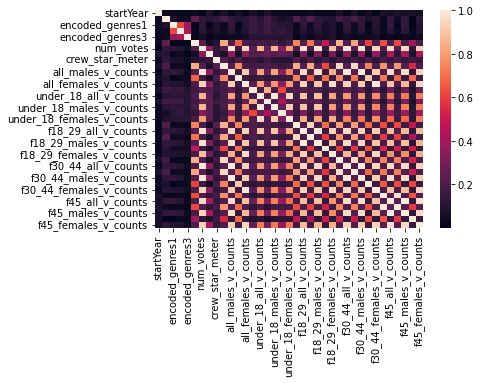

In [243]:
sns.heatmap(abs(imdb_megadata3.corr()))